In [1]:
import pandas as pd
import pandas_profiling as pp
import numpy as np
import matplotlib.pyplot as plt

%matplotlib inline

In [19]:
offense = pd.read_csv('data/offense.csv', index_col=0)
defense = pd.read_csv('data/defense.csv', index_col=0)
salary = pd.read_csv('data/salary.csv', index_col=0)
salary.columns = ['Team', 'Year'] + list(salary.columns[2:])
standings = pd.read_csv('data/standings.csv', index_col = 0)

In [21]:
combined = pd.merge(offense, defense, on=['Team', 'Year'], suffixes=('_off', '_def'))
combined = pd.merge(combined, salary, on=['Team', 'Year'])
combined.columns

Index(['Team', 'Year', 'Yds/G_rush_off', 'TD_rush_off', 'Yds/G_pass_off',
       'Pct_off', 'TD_pass_off', 'Sck_off', 'Rate_off', 'Pts/G_off',
       'Pen Yds_off', 'TO', 'Yds/G_rush_def', 'TD_rush_def', 'Yds/G_pass_def',
       'TD_pass_def', 'Rate_def', 'Sck_def', 'Pct_def', 'Pts/G_def',
       'Pen Yds_def', 'DL', 'LB', 'OL', 'QB', 'RB', 'S', 'ST', 'TE', 'WR',
       'nDL', 'nLB', 'nOL', 'nQB', 'nRB', 'nS', 'nST', 'nTE', 'nWR'],
      dtype='object')

In [24]:
pp.ProfileReport(combined)

Number of variables,39
Number of observations,160
Total Missing (%),0.0%
Total size in memory,50.0 KiB
Average record size in memory,320.0 B
Numeric,38
Categorical,1
Boolean,0
Date,0
Text (Unique),0
Rejected,0


In [41]:
corr.shape

(37, 37)

ValueError: Data supplied to "annot" must be the same shape as the data to plot.

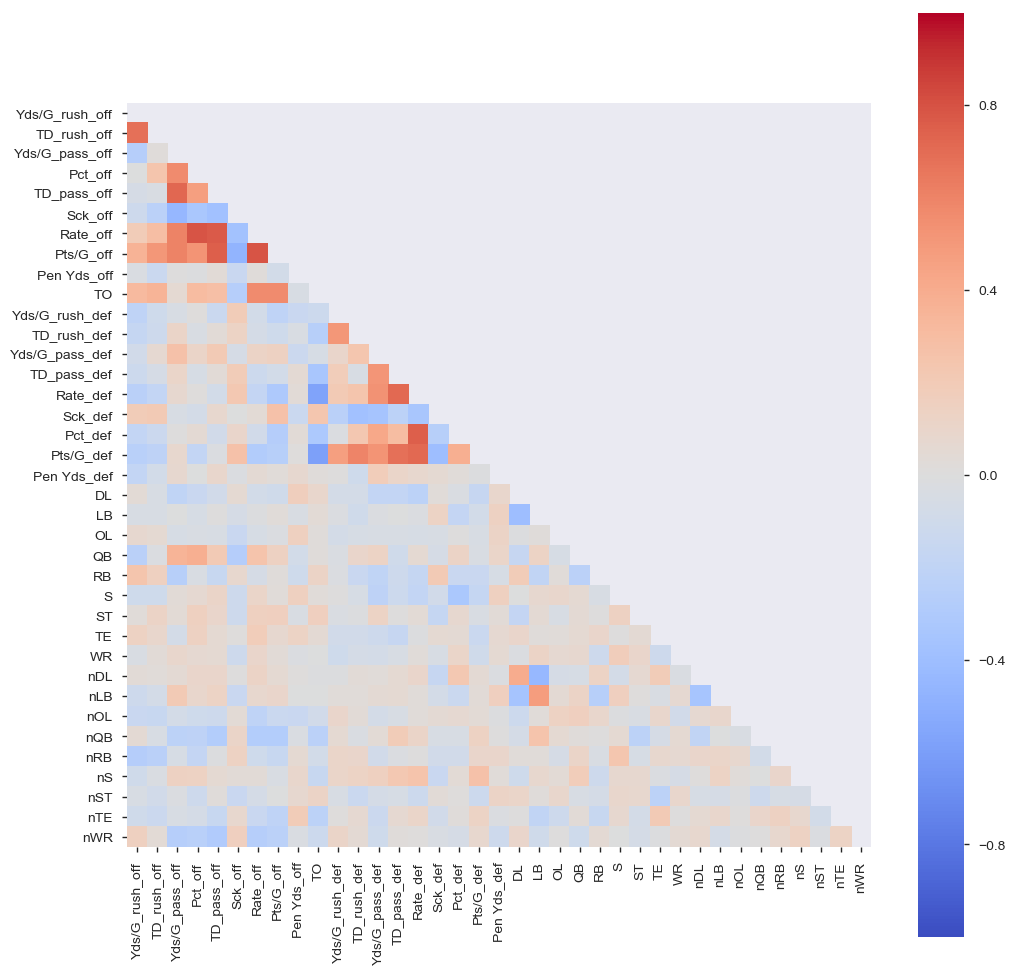

In [47]:
corr = combined[combined.columns[2:]].corr()

import seaborn as sns
from matplotlib.colors import ListedColormap

labels = corr.where(np.triu(np.ones(corr.shape)).astype(np.bool))
labels = labels.replace(np.nan,' ', regex=True)

fig, ax = plt.subplots(1, 1, figsize=(12, 12))

mask = np.triu(np.ones(corr.shape)).astype(np.bool)

_ = sns.heatmap(corr, mask=mask, vmin=-1, vmax=1, cmap='coolwarm', square=True, ax=ax)

mask = np.ones((37, 37))-mask

_ = sns.heatmap(corr, mask=mask, cmap=ListedColormap(['white']),annot=corr.columns,cbar=False, fmt='', linewidths=1.5, ax=ax)

In [38]:
corr

,Year,Yds/G_rush_off,TD_rush_off,Yds/G_pass_off,Pct_off,TD_pass_off,Sck_off,Rate_off,Pts/G_off,Pen Yds_off,...,WR,nDL,nLB,nOL,nQB,nRB,nS,nST,nTE,nWR
Year,1.000000,-0.064644,0.002890,-0.075382,0.090414,-0.089674,-0.128605,0.032703,-0.109254,0.203019,...,0.309919,0.064251,0.080846,0.042813,0.078070,0.184895,0.180370,0.065938,0.115541,0.160106
Yds/G_rush_off,-0.064644,1.000000,0.684837,-0.265325,-0.000192,-0.057269,-0.109803,0.188695,0.359553,-0.030591,...,-0.031561,0.032760,-0.112956,-0.144744,0.053822,-0.265681,-0.100567,-0.039474,-0.095537,0.148767
TD_rush_off,0.002890,0.684837,1.000000,0.015921,0.244618,-0.033993,-0.228111,0.292318,0.515077,-0.136559,...,0.032599,0.028474,-0.077290,-0.151842,-0.039089,-0.238031,-0.026693,-0.087664,-0.129618,0.044318
Yds/G_pass_off,-0.075382,-0.265325,0.015921,1.000000,0.565024,0.721913,-0.447760,0.601918,0.604297,0.006709,...,0.093106,0.049057,0.206902,-0.075074,-0.220895,-0.046911,0.147739,-0.022776,-0.044029,-0.260253
Pct_off,0.090414,-0.000192,0.244618,0.565024,1.000000,0.470674,-0.335520,0.793332,0.525765,-0.007981,...,0.069409,0.094565,0.088255,-0.103950,-0.213993,-0.171887,0.137335,-0.110062,-0.065109,-0.248758
TD_pass_off,-0.089674,-0.057269,-0.033993,0.721913,0.470674,1.000000,-0.378290,0.765705,0.757031,0.032374,...,0.059728,0.099584,0.131609,-0.115822,-0.275544,-0.014812,0.061026,0.019308,-0.154738,-0.293302
Sck_off,-0.128605,-0.109803,-0.228111,-0.447760,-0.335520,-0.378290,1.000000,-0.374762,-0.469757,-0.143465,...,-0.113265,0.002071,-0.142365,0.040015,0.117003,0.134295,0.038345,-0.145082,0.084960,0.162325
Rate_off,0.032703,0.188695,0.292318,0.601918,0.793332,0.765705,-0.374762,1.000000,0.789929,0.016115,...,0.097992,0.121851,0.081574,-0.205982,-0.273611,-0.105983,0.031865,-0.067478,-0.142285,-0.259126
Pts/G_off,-0.109254,0.359553,0.515077,0.604297,0.525765,0.757031,-0.469757,0.789929,1.000000,-0.083319,...,0.038796,0.057091,0.094477,-0.139879,-0.278546,-0.155277,-0.037740,-0.005634,-0.210433,-0.231689
Pen Yds_off,0.203019,-0.030591,-0.136559,0.006709,-0.007981,0.032374,-0.143465,0.016115,-0.083319,1.000000,...,-0.017935,0.013285,-0.006690,-0.147307,-0.028532,0.055332,0.090995,0.075757,0.191274,-0.030265
